In [8]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cython
from pathlib import Path
from os.path import join
from IPython.display import display_markdown
sns.set()

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [9]:
%%cython
cimport cython
cimport numpy as np
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def list_of_sequence_length(np.ndarray a, slippy=True, aside=None):
    if aside is not None:
        aside = aside.values
    cdef int curi = 0
    cdef int i
    cdef int actu = -1
    out = []
    for i in range(len(a)):
        if actu != a[i] and (a[i] != 0 or not slippy):
            if curi > 0:
                out.append([val, curi])
            curi = 0
            actu = a[i]
            if aside is not None:
                val = aside[i]
            else:
                val = actu
        if a[i] == actu and a[i] != 0:
            curi += 1
    if curi != 0:
        out.append([val, curi])
    return out


def sequence_length(a, slippy=True, aside=None):
    return list_of_sequence_length(a.values, slippy, aside)



def sequence_length_mean(a, slippy=True, aside=None):
    elems = sequence_length(a, slippy, aside)
    if elems:
        return np.mean(elems)
    else:
        return np.NaN


In [10]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(path + '.gz', *args, **kwargs)
    except: 
        return pd.read_csv(path, *args, **kwargs)

# /data/logs/trash/oldschoolbm/rep00//analysis_log_19999.txt

/data/logs/trash/oldschoolbm/rep00/../fit.txt


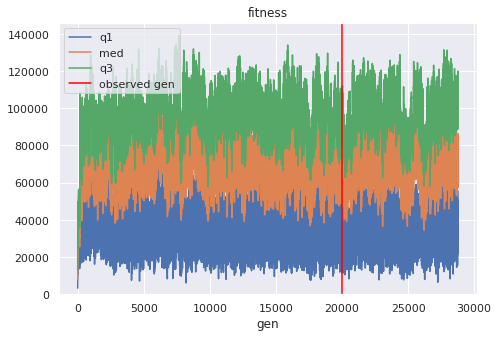

/data/logs/trash/oldschoolbm/rep00/logall_19999.txt


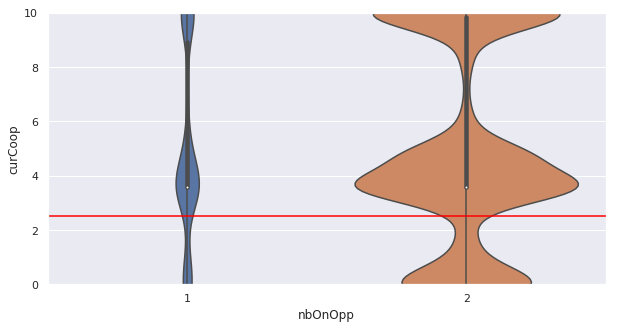

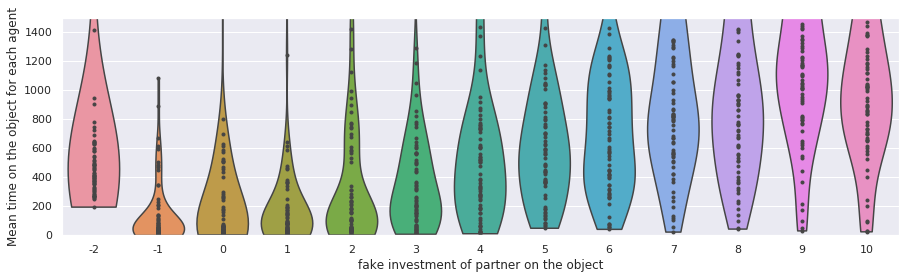

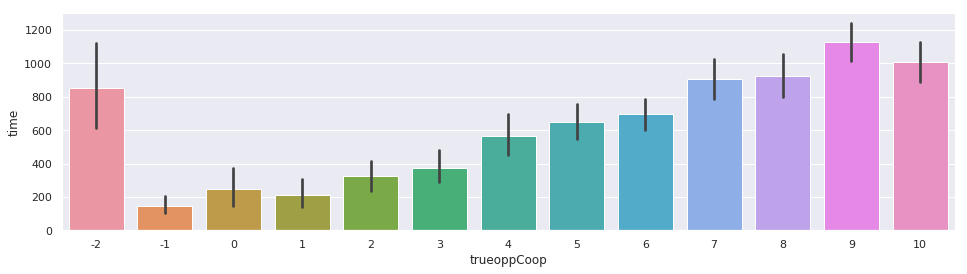

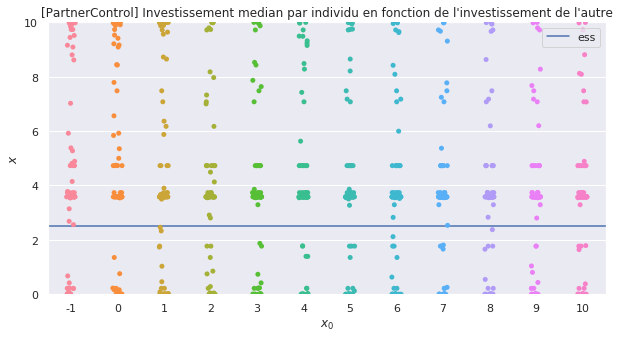

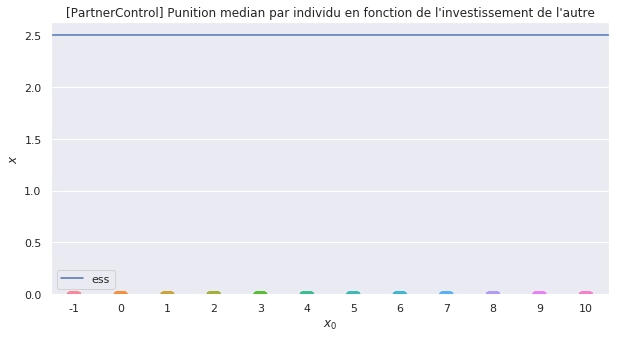

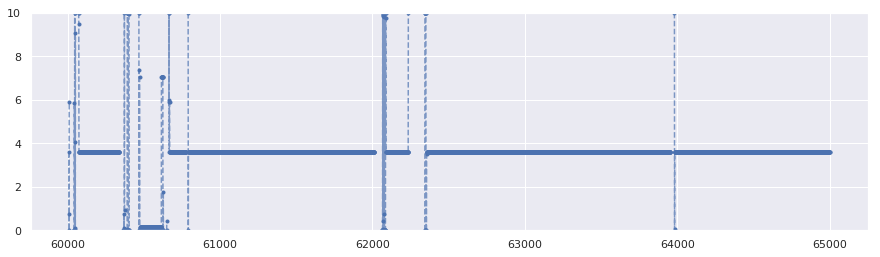

In [12]:
from itertools import product
force = False
runs = range(1, 2)
for run, num in product(runs, [19999]):
    path = f"/data/logs/s2700-see-noizi-uniform-fit-partnercontrol-2018-10-25-1814/canonical_bm_tp/run_{run:02}/rep{{}}/"
    path = f"/data/logs/trash/oldschoolbm/rep{{}}/"
    
    path = path.format('00')
    slippy = True
    if not slippy and not 'tp' in path : 
        print("Attention, activer slippy ?????")
        
    logpath = f"{path}/analysis_log_{num}.txt"
    display_markdown("# " + logpath, raw=True)

    fail = False
    fig, ax = plt.subplots(figsize=(5*1.5,5))

    try:
        fitpath = Path(path) / "../fit.txt"
        fit = pd.read_csv(fitpath, delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
    except Exception as e:
        print('fail with', fitpath)
        try:
            fit = read_csvx(str(fitpath), delimiter="\t")
        except Exception as e:
            print(type(e), e)
            pass
        
    else:
        print(fitpath)
    fit.plot(x='gen', y='q1', ax=ax)
    fit.plot(x='gen', y='med', ax=ax)
    fit.plot(x='gen', y='q3', ax=ax)
    ax.set_ylim(0, None)


    ax.axvline(num, label="observed gen", color="red")
    ax.legend()
    ax.set_title('fitness')
    plt.show(fig)

    logfile = join(path, f'logall_{num}.txt')
    i = 0
    ok = True
    to_format = '{' in logfile
    logs = []
    while ok:
        try:
            print(logfile.format(i))
            dat = read_csvx(logfile.format(i), delimiter="\t")
            dat["eval"] = i
            logs.append(dat)
        except Exception as e:
            print(type(e), e)
            ok = False
        else:
            i += 1
            ok = to_format
    try:
        if ('1p1' in path):
            log = pd.concat(logs).query('fake == 0 and id < 90').copy() # Fakes are removed from data
        else:
            log = pd.concat(logs).query('fake == 0').copy() # Fakes are removed from data
    except Exception as e:
        plt.show(fig)
        print("no data, continue")
        print(type(e), ':', e)
        continue
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
    sns.violinplot(data=log.query('1 <= nbOnOpp <= 2 and onOpp == 1'), x='nbOnOpp', y='curCoop', cut=0, ax=ax2, scale='count')
    ax2.axhline(2.5, color="red")
    ax2.set_ylim(0, 10)
    plt.show(fig)
    
    
    try:
        df = read_csvx(logpath, delimiter="\t").query('ind < 90').copy()
    except Exception as e:
        print(type(e), e)
        continue

    df['trueoppCoop'] = np.where((df['oppId'] == 0), -2, df['oppCoop'])
    df['trueoppCoop'] = np.where((df['oppId'] > 0) & (df['oppNb'] == 0), -1, df['trueoppCoop'])
    #df['trueoppCoop'] = pd.Categorical(df['trueoppCoop'], categories=['cherche', 'seul'] + list(range(0, 11)), ordered=True)
    df['onOpp'] = np.where(df['oppId'] > 0, 1, 0)
    df['justarrived'] = df['onOpp'].diff() == 1

    #timespent = df.groupby(['ind', 'rep']).apply(lambda x : pd.DataFrame(sequence_length(x['oppId'], slippy, x['trueoppCoop']), columns=['trueoppCoop', 'time'])).reset_index().infer_objects()
    
    # Here, we take the total amount of time spent on each type of coop unit per rep
    timespent = df.groupby(['trueoppCoop', 'ind', 'rep'], as_index=False).count()
    timespent = timespent.groupby(['ind', 'trueoppCoop'], as_index=False).mean().copy()
    timespent['time'] = timespent['onOpp']
    
    
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.violinplot(data=timespent, x='trueoppCoop', y='time', cut=0, scale="width", inner="points", ax=ax)
    ax.set_ylim(0, 1500)

    #plt.ylim(0,500)
    plt.ylabel('Mean time on the object for each agent')
    plt.xlabel('fake investment of partner on the object');
    #plt.ylabel('')
    #plt.xlabel('');
    plt.show(fig)
    fig.savefig('partnerchoice.svg')

    fig, ax = plt.subplots(figsize=(16, 4))
    sns.barplot(data=timespent, x='trueoppCoop', y='time', ax=ax)
    plt.show(fig)


    df['truecoop'] = np.where(df['onOpp'], df['ownCoop'], np.nan)
    # df.loc[np.where(np.isnan(df['truecoop']))[0] + 1, 'truecoop'] = np.nan
        
    
    fig, ax = plt.subplots(figsize=(10, 5))
    #sns.violinplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), cut=0, x='trueoppCoop', y='ownCoop', scale='count', inner='points')
    sns.stripplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), x='trueoppCoop', y='truecoop')
    #sns.violinplot(data=df.query('onOpp > 0'), cut=0, x='trueoppCoop', y='ownCoop', scale='count')
    ax.axhline(2.5, label='ess')
    ax.set_title("[PartnerControl] Investissement median par individu en fonction de l'investissement de l'autre")
    ax.legend()
    ax.set_ylabel("$x$")
    ax.set_xlabel("$x_0$")
    ax.set_ylim(0, 10);
    plt.show(fig)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    #sns.violinplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), cut=0, x='trueoppCoop', y='ownCoop', scale='count', inner='points')
    try:
        sns.stripplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), x='trueoppCoop', y='spite')
    except Exception as e:
        print(type(e), e)
    else:
        #sns.violinplot(data=df.query('onOpp > 0'), cut=0, x='trueoppCoop', y='ownCoop', scale='count')
        ax.axhline(2.5, label='ess')
        ax.set_title("[PartnerControl] Punition median par individu en fonction de l'investissement de l'autre")
        ax.legend()
        ax.set_ylabel("$x$")
        ax.set_xlabel("$x_0$")
        ax.set_ylim(0, None);
    finally:
        plt.show(fig)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    df.query('ind == 1 and rep == 2')['truecoop'].plot(ax=ax, style='.')
    df.query('ind == 1 and rep == 2')['truecoop'].plot(ax=ax, style='--', alpha=0.7, c=sns.palettes.get_color_cycle()[0])
    ax.set_ylim(0, 10)
    plt.show(fig)

    if False:
        best = df.groupby('ind', as_index=False).mean()['truecoop'].nlargest(20).index
        worst = df.groupby('ind', as_index=False).mean()['truecoop'].nsmallest(20).index

        timespent.loc[np.where(timespent['ind'].isin(best))[0], 'good'] = 'Cooperateur'
        timespent.loc[np.where(timespent['ind'].isin(worst))[0], 'good'] = 'Egoiste'

        plt.figure(figsize=(11, 4))
        sns.violinplot(data=timespent, x='trueoppCoop', y='time', cut=0, scale='count', hue='good', split=True)
        plt.title("Temps passé sur un objet en fonction de la coopération du faux robot, temps moyen par individu")
        plt.ylabel("% temps sur un objet")
        plt.xlabel("$x_0$ : investissement du robot partenaire");
        plt.show()

In [26]:
################
#% CONF LOADER #
################

import os.path
medcooplist = []
num = 9999
conds = [
         ('partnerChoice', "/data/logs/s2700-see-noizi-uniform-fit-2018-10-23-1710/canonical_bm_tp/"),
         ('partnerControl', "/data/logs/s2700-see-noizi-uniform-fit-partnercontrol-2018-10-25-1814/canonical_bm_tp/"),
         #('punish', "/data/logs/s2700-see-noizi-uniform-fit-punish-2018-10-24-1730/canonical_bm_tp")
        ]
for condname, catpath in conds:
    run = 1
    if (os.path.exists(os.path.join(catpath, "run_{run:02}/rep00/".format(run=run)))):
        path = os.path.join(catpath, "run_{run:02}/rep00/")
    else:
        path = os.path.join(catpath, "run_{run}/rep00/")
    print(path.format(run=run))
    while os.path.exists(path.format(run=run)):
        logfile = join(path.format(run=run), f'logall_{num}.txt')
        i = 0
        ok = True
        to_format = '{' in logfile
        logs = []
        while ok:
            try:
                dat = read_csvx(logfile.format(i), delimiter="\t")
                dat["eval"] = i
                logs.append(dat)
            except:
                ok = False
            else:
                i += 1
                ok = to_format
        try:
            log = pd.concat(logs).query('fake == 0').copy() # Fakes are removed from data
        except Exception as e:
            raise e
            plt.show(fig)
            print("no data, continue")
        med = log.query('nbOnOpp == 2 and onOpp > 0')['curCoop'].mean()
        print(run, ':', med)
        medcooplist.append({'run': condname,
                            'iter': run,
                            'medcoop': med})
        run += 1

/data/logs/s2700-see-noizi-uniform-fit-2018-10-23-1710/canonical_bm_tp/run_01/rep00/
1 : 8.062592285008868
2 : 8.099989562265655
3 : 6.3351017989439775
4 : 8.228312091058497
5 : 5.475428405947056
6 : 6.499208657946166
7 : 4.421222299336104
8 : 3.351837370565603
9 : 3.651199082768431
10 : 7.317835928605712
11 : 3.6182688132321443
12 : 7.670827533054737
13 : 7.5694935833084935
14 : 5.727495810652193
15 : 4.402812260691653
/data/logs/s2700-see-noizi-uniform-fit-partnercontrol-2018-10-25-1814/canonical_bm_tp/run_01/rep00/
1 : 4.2373999814891095
2 : 2.937006086264045
3 : 2.2928317565654166
4 : 2.9883869488774
5 : 4.603225584578655
6 : 3.5229435607870254
7 : 2.6106444599884253
8 : 3.3871589925371985
9 : 2.44389699966821
10 : 2.3212834983127495
11 : 2.181112376385689
12 : 4.529805416887982
13 : 3.3880827888666984
14 : 0.45141595809620955
15 : 2.9165044048561595


In [27]:
force = True
if force:
    try:
        del medcoop
    except NameError:
        pass
try:
    medcooptmp = pd.DataFrame(medcooplist)
    for condname in medcooptmp['run'].unique():
        if condname in medcoop['run'].unique():
            print(f'{condname} already in batch, abort')
        else:
            medcoop = medcoop.append(medcooptmp.query(f'run == "{condname}"'))
except:
    medcoop = pd.DataFrame(medcooplist)

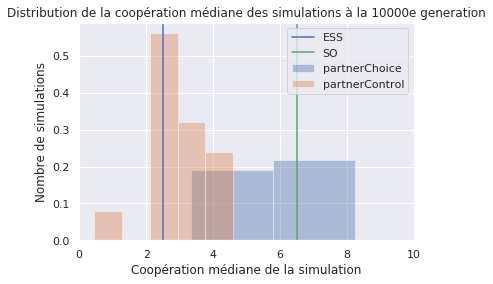

In [28]:
comps = [cond[0] for cond in conds]
for comp in comps:
    sns.distplot(medcoop.query(f'run == "{comp}"')['medcoop'], label=comp, norm_hist=True, hist=True, kde=False, bins=None, kde_kws={'shade': True})
plt.axvline(2.5, label="ESS")
plt.axvline(6.5, c="g", label="SO")
plt.xlim(0, 10)
plt.ylabel("Nombre de simulations")
plt.xlabel(f"Coopération médiane de la simulation")
plt.title(f"Distribution de la coopération médiane des simulations à la {num+1}e generation")
plt.legend()

In [38]:
sp.stats.wilcoxon(medcoop.query(f'run == "{comps[0]}"')['medcoop'], medcoop.query(f'run == "{comps[1]}"')['medcoop'])

NameError: name 'sp' is not defined

In [ ]:
plt.plot()